In [1]:
import sys
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
%matplotlib inline

sys.path.append('../')

from dstft.loss import entropy_loss, entropyt_loss, kurtosis_loss, scale_loss
from dstft import DSTFT

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.Size([1, 6636]) cuda:0 torch.float32
[0, 1484, 2637, 3272, 3633, 5429, 6636]


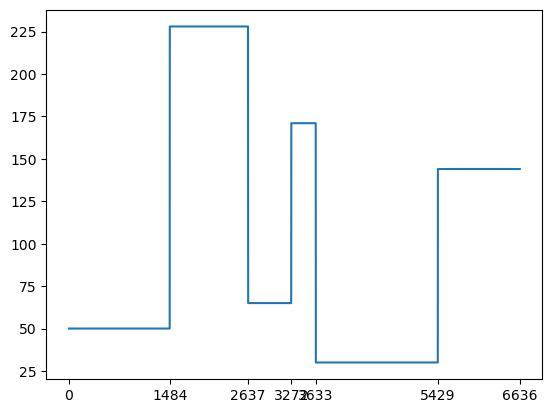

In [2]:
sr = 1e3
sizes = [1484, 1153, 635, 361, 1796, 1207]
freqs = [50, 228, 65, 171, 30, 144,]
f = freqs[0] * (torch.ones(sizes[0]) + .0 * torch.randn(sizes[0]))
for i in range(1, len(freqs)):
    f = torch.cat((f, freqs[i]  * (torch.ones(sizes[i]) + .0 * torch.randn(sizes[i]))))
f = f + 0. * torch.ones_like(f) * torch.randn_like(f)

x = torch.sin(2*pi*torch.cumsum(f, 0)/sr)
x += 0.2 * torch.randn(x.shape)
x = x[None, :].to(device)
print(x.shape, x.device, x.dtype)

mark_list = np.cumsum(sizes).tolist()
mark_list.insert(0, 0)
print(mark_list)

plt.figure()
plt.plot(f)
plt.xticks(mark_list)
plt.show()

torch.Size([11]) tensor([-461.5000,  500.0000, 1000.0000, 1500.0000, 2000.0000, 2500.0000,
        3000.0000, 3500.0000, 4000.0000, 4500.0000, 5000.0000],
       device='cuda:0')
torch.Size([11]) tensor([-461.5000,  500.0000, 1000.0000, 1500.0000, 2000.0000, 2500.0000,
        3000.0000, 3500.0000, 4000.0000, 4500.0000, 5000.0000],
       device='cuda:0')
torch.Size([11]) tensor([-461.5000,  500.0000, 1000.0000, 1500.0000, 2000.0000, 2500.0000,
        3000.0000, 3500.0000, 4000.0000, 4500.0000, 5000.0000],
       device='cuda:0')
torch.Size([11]) tensor([-461.5000,  500.0000, 1000.0000, 1500.0000, 2000.0000, 2500.0000,
        3000.0000, 3500.0000, 4000.0000, 4500.0000, 5000.0000],
       device='cuda:0')
torch.Size([11]) tensor([-461.5000,  500.0000, 1000.0000, 1500.0000, 2000.0000, 2500.0000,
        3000.0000, 3500.0000, 4000.0000, 4500.0000, 5000.0000],
       device='cuda:0')
torch.Size([11]) tensor([-461.5000,  500.0000, 1000.0000, 1500.0000, 2000.0000, 2500.0000,
        3000.0

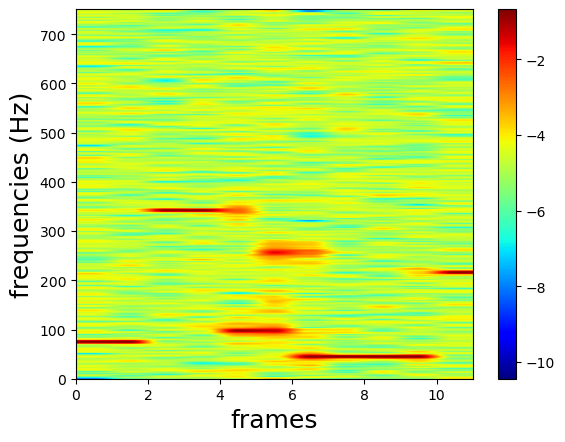

torch.Size([11]) tensor([-461.5000,  500.0000, 1000.0000, 1500.0000, 2000.0000, 2500.0000,
        3000.0000, 3500.0000, 4000.0000, 4500.0000, 5000.0000],
       device='cuda:0')


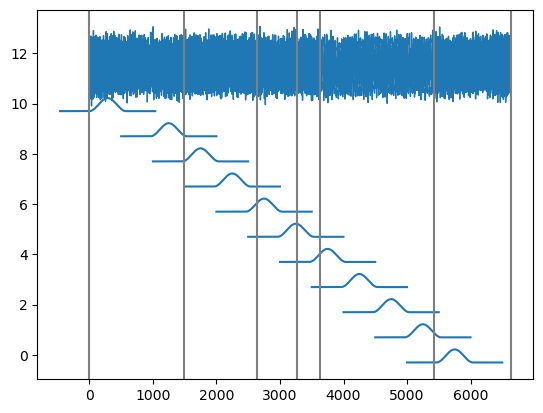

In [3]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=False, stride_requires_grad=False, win_p='tf', stride_p=None)
spec, *_ = dstft(x)
print(dstft.coverage())
print(kurtosis_loss(spec).mean().shape)
dstft.print(spec, x, weights=False, bar=True, marklist=mark_list)

In [ ]:
# dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
# params = [ {'params': dstft.parameters(),   'lr': 4.0}]
# opt = torch.optim.Adam(params)
# sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

# for epoch in range(10_000):
#     #scale = scale_loss(dstft, x)
    
#     opt.zero_grad()    
#     spec, *_ = dstft(x)
#     loss1 = 1_000 / kurtosis_loss(spec).mean()
    
#     print(dstft.T)    
#     eff_stride = dstft.effective_strides
#     print(eff_stride.shape, eff_stride)
#     aaa
    
    
    
#     err = 1_000 * weight / kurtosis_loss(spec).mean()
#     err.backward()
#     opt.step()
#     sch.step(err)
    
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch:.0f};\t Err {err:.2f}")
    
#     if epoch % 100 == 0:
#         dstft.print(spec, x, marklist=mark_list, bar=True)
    
#     if opt.param_groups[0]['lr'] < 1:
#         break

# print(epoch)
# dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
# dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
# params = [ {'params': dstft.parameters(),   'lr': 8.0}]
# opt = torch.optim.Adam(params)
# sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

# for epoch in range(10_000):
#     scale = scale_loss(dstft, x)
    
#     opt.zero_grad()    
#     spec, *_ = dstft(x)
#     loss1 = 1_000 / kurtosis_loss(spec).mean()
#     loss2 = 1_000 * (1 - dstft.coverage())
    
#     err = scale['loss1'] * loss1 + scale['loss2'] * loss2
#     err.backward()
#     opt.step()
#     sch.step(err)
    
#     if epoch % 10 == 0:
#         loss = loss1 + loss2
#         print(f"Epoch {epoch:.0f}; \t loss {loss:.2f}; \t Err {err:.2f};\t loss1 {loss1:.2f};\t loss2 {loss2:.2f};\t Scales {scale} ")
    
#     if epoch % 100 == 0:
#         dstft.print(spec, x, marklist=mark_list, bar=True)
    
    
#     if opt.param_groups[0]['lr'] < 1:
#         break

# print(epoch)
# dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
# dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
# params = [{'params': dstft.parameters(), 'lr': 4.0}, ] 
# opt = torch.optim.Adam(params)
# sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

# for epoch in range(10_000):
#     opt.zero_grad()    
#     spec, *_ = dstft(x)
#     err = 100_000 * (2-dstft.coverage()) / kurtosis_loss(spec).mean() 
#     if epoch % 100 == 0: print(err, dstft.coverage() )
#     err.backward()
#     opt.step()
#     sch.step(err)
    
#     if opt.param_groups[0]['lr'] < 1:
#         break
    
# print(epoch, err)
# print(dstft.actual_strides)
# dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
# dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)

# params1 = [{'params': dstft.win_length, 'lr': 4.0}]
# opt1 = torch.optim.Adam(params1)
# sch1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt1, mode='min', factor=.5, patience=9, verbose=True)

# params2 = [{'params': dstft.strides, 'lr': 8.0}]
# opt2 = torch.optim.Adam(params2)
# sch2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt2, mode='min', factor=.5, patience=1, verbose=True)

# for epoch in range(10_000):
#     opt1.zero_grad()  
#     opt2.zero_grad()
#     spec, *_ = dstft(x)
#     err = 1000 / kurtosis_loss(spec).mean()
#     if epoch % 100 == 0: print(err)
#     err.backward()
#     opt1.step()
#     sch1.step(err)
#     opt2.step()
#     sch2.step(err)
    
#     if opt2.param_groups[0]['lr'] < 1:
#         print('end')
#         break
    
# print(epoch)
# dstft.print(spec, x, marklist=mark_list, bar=True)

Time-varying window length

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 1.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 == 0: print(epoch, err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 1.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

time-varying hop length

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=False, stride_requires_grad=True, win_p=None, stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 1.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()    
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch, err)
dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
dstft = DSTFT(x, win_length=500, support=1_500, stride=500, win_requires_grad=False, stride_requires_grad=True, win_p=None, stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 1.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec).mean()    
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch, err)
dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=False, stride_requires_grad=True, win_p=None, stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 1.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean() 
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 == 0: print(epoch, err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch, err)
dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
dstft = DSTFT(x, win_length=500, support=1_500, stride=250, win_requires_grad=False, stride_requires_grad=True, win_p=None, stride_p='t', win_min=100)
params = [{'params': dstft.parameters(), 'lr': 1.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 == 0: print(epoch, err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch, err)
dstft.print(spec, x, marklist=mark_list, bar=True)

Time-varying window and hop length

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [{'params': dstft.parameters(),   'lr': 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 == 0: print(epoch, err)

    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [{'params': dstft.parameters(),   'lr': 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 == 0: print(epoch, err)

    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [{'params': dstft.parameters(),   'lr': 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 == 0: print(epoch, err)

    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Time-and-frequency varying window length and time-varying hop length

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100)
params = [{'params': dstft.parameters(),   'lr': 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(100_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 == 0: print(epoch, err)

    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100)
params = [{'params': dstft.parameters(),   'lr': 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean() + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 == 0: print(epoch, err)

    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=250, win_requires_grad=True, stride_requires_grad=True, win_p='tf', stride_p='t', win_min=100)
params = [{'params': dstft.parameters(),   'lr': 1.0}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(10_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = 1_000 / kurtosis_loss(spec).mean().mean() + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()   
    err.backward()
    opt.step()
    sch.step(err)
    
    if epoch % 100 == 0: print(epoch, err)

    if opt.param_groups[0]['lr'] < .1:
        break
    
print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

Multi objective optimization

In [ ]:
dstft = DSTFT(x, win_length=577, support=1_500, stride=500, win_requires_grad=True, stride_requires_grad=True, win_p='t', stride_p='t', win_min=100)
params = [ {'params': dstft.parameters(),   'lr': 4.0}]
opt = torch.optim.Adam(params)
sch =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.5, patience=99, verbose=True)

for epoch in range(10_000):
    scale = scale_loss(dstft, x)
    
    opt.zero_grad()    
    spec, *_ = dstft(x)
    loss1 = 100_000 * (1 / kurtosis_loss(spec).mean())
    loss2 = 1_000 * (1 - dstft.coverage())
    
    err = scale['loss1'] * loss1 + scale['loss2'] * loss2
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, marklist=mark_list, bar=True)

KeyboardInterrupt: 